In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#import custom modules
import sys
sys.path.insert(0,'/Users/frederickkorbel/Documents/projects/paper/mlcis/utils')

import integrated_gradients as ig
import my_utils
from metaplot import Metaplot,one_hot_encode
import plotseqlogo as sql

/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/plotseqlogo.py:53: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/plotseqlogo.py:54: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


We devise a function to summarize different populations of utr reporters depending on their mean ribosome load measure and plot meta-attribution maps for each population

In [3]:
from matplotlib.cbook import safe_masked_invalid


def plot_meta(data, model, subset=None):

    if subset is None:
        print(len(data))
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        Metaplot(data_ig, colorbar = True)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)]
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        Metaplot(lowest_ten_ig, colorbar = True)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)]
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        Metaplot(highest_ten_ig, colorbar = True)
        
    else:
        raise ValueError()

def plot_attribution(data, model, subset=None, samples=10):
    if subset is None:
        print(len(data))
        data = data.sample(n=samples)
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        sql.seqlogo_fig(np.transpose(data_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)].sample(n=samples)
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        sql.seqlogo_fig(np.transpose(lowest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)].sample(n=samples)
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        sql.seqlogo_fig(np.transpose(highest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
        
    else:
        raise ValueError()

We import all data and the two models (MRL, hMRL) and quantify the occurence of start codons, uORFs and their respective positions.

In [4]:
#import utrs with measured and predicted mean ribosome load

#synthetic utrs with mean ribosome load predicted by MRL model (published model by Sample et. al)
test_random=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_random_test_pred.csv', index_col=[0])

#human utrs with mean ribosome load predicted by hMRL model (trained on human utrs in this study)
test_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_human_test_pred.csv', index_col=[0])

#import the two models trained on human/synthetic utrs respectively
mrl_model=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/main_MRL_model.hdf5')
hmrl_model=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model.hdf5')

#quantify occurence of ATGs, uORFs and their positions
test_random=my_utils.analyze(test_random)
test_human=my_utils.analyze(test_human)

2022-08-09 10:35:34.610557: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


For each of the two modelling conditions, we generate attribution maps for random examples and meta-attribution maps for subpopulations

First, for the main MRL model published by Sample et. al trained (and predicted= on synthetic utrs 

3


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


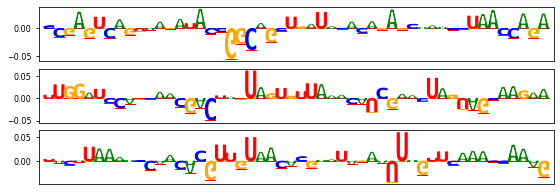

In [4]:
plot_attribution(test_random, mrl_model, subset='highest_ten', samples=3)

2000


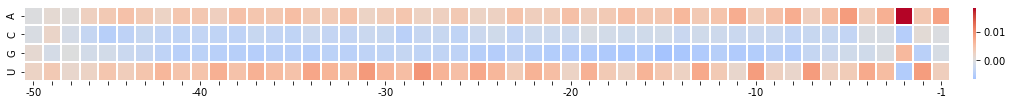

In [5]:
plot_meta(test_random, mrl_model, subset='highest_ten')

3


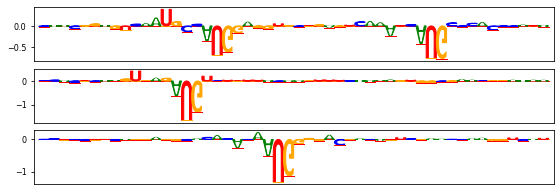

In [6]:
plot_attribution(test_random, mrl_model, subset='lowest_ten', samples=3)

2000


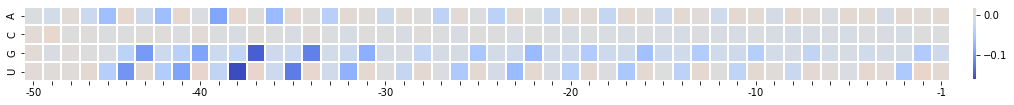

In [7]:
plot_meta(test_random, mrl_model, subset='lowest_ten')

Second, for the hMRL model, trained and predicted on human utrs

3


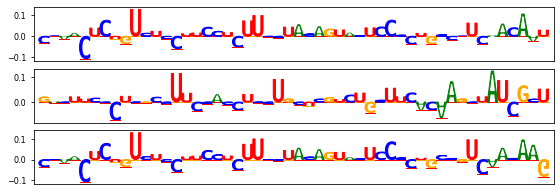

In [8]:
plot_attribution(test_human, hmrl_model, subset='highest_ten', samples=3)

500


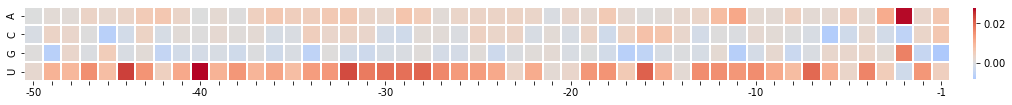

In [9]:
plot_meta(test_human, hmrl_model, subset='highest_ten')

3


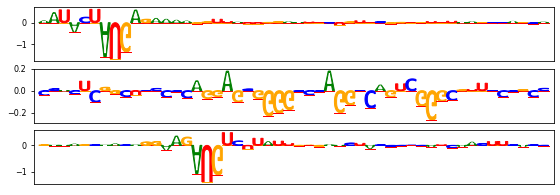

In [10]:
plot_attribution(test_human, hmrl_model, subset='lowest_ten', samples=3)

500


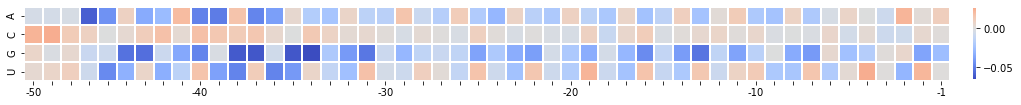

In [11]:
plot_meta(test_human, hmrl_model, subset='lowest_ten')

Since we can clearly reproduce the general repressive effect of upstream translation, we want to characterize the effect that the presence of one uORF has on ribosome load of the reporter. Therefore, we devise five groups, each representing specific cases of upstream translation, to uncover individual frame- and position-dependent effects of uAUGs and uORFs captured by the deep learning model.

First, we divide into the respective groups:
1. no uAUG (no upstream translation from canonical start codons) = control
2. one uORF (AUG+STOP) in-frame with mORF
3. one uORF (AUG+STOP) out-of-frame with mORF
4. one uAUG without STOP in-frame with mORF
5. one uAUG without STOP out-of-frame with mORF

In [5]:
#separate categories
#& test_human['utr'].apply(lambda x: x.startswith('TG')== False)

# no uAUG (=control)
no_uaug_random = test_random[test_random['utr'].apply(lambda x: 'ATG' not in x) & test_random['utr'].apply(lambda x: x.startswith('TG')== False)]
no_uaug_human = test_human[test_human['utr'].apply(lambda x: 'ATG' not in x) & test_human['utr'].apply(lambda x: x.startswith('TG')== False)]
# IF uORFs
if_uorf_random = test_random[(test_random['aug_number'] == 1) & (test_random['orfs_inframe'].map(lambda x: x[0]) == 1)]
if_uorf_human = test_human[(test_human['aug_number'] == 1) & (test_human['orfs_inframe'].map(lambda x: x[0]) == 1)]
# OOF uORFs
oof_uorf_random = test_random[(test_random['orf_number'] == 1) & (test_random['aug_number'] == 1) & (test_random['orfs_inframe'].map(lambda x: x[0]) == 0)]
oof_uorf_human = test_human[(test_human['orf_number'] == 1) & (test_human['aug_number'] == 1) & (test_human['orfs_inframe'].map(lambda x: x[0]) == 0)]
# IF uAUG (N-terminal extension)
if_uaug_random = test_random[(test_random['orf_number'] == 0) & (test_random['aug_number'] == 1) & (test_random['aug_inframe'] == 1)]
if_uaug_human = test_human[(test_human['orf_number'] == 0) & (test_human['aug_number'] == 1) & (test_human['aug_inframe'] == 1)]
# OOF uAUG (overlapping uORF)
oof_uaug_random = test_random[(test_random['orf_number'] == 0) & (test_random['aug_number'] == 1) & (test_random['aug_inframe'] == 0)]
oof_uaug_human = test_human[(test_human['orf_number'] == 0) & (test_human['aug_number'] == 1) & (test_human['aug_inframe'] == 0)]
#ambiguous (multiple and/or mixed uAUGs/uORFs)
amb_random = test_random[(test_random['orf_number'] + test_random['aug_number']) >= 2]
amb_human = test_human[(test_human['orf_number'] + test_random['aug_number']) >= 2]

/var/folders/6b/4m6tvsws1rvb767d463fsk7r0000gn/T/ipykernel_28230/3979519271.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  amb_human = test_human[(test_human['orf_number'] + test_random['aug_number']) >= 2]


In [6]:
utrans_random = [no_uaug_random, if_uorf_random, oof_uorf_random, if_uaug_random, oof_uaug_random]
utrans_human = [no_uaug_human, if_uorf_human, oof_uorf_human, if_uaug_human, oof_uaug_human]

We generate attribution- and meta-attribution plots for the main MRL model published by Sample et. al

5813


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


704
1343
1431
5297


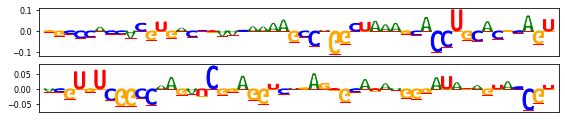

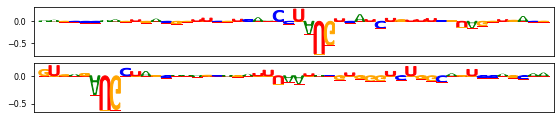

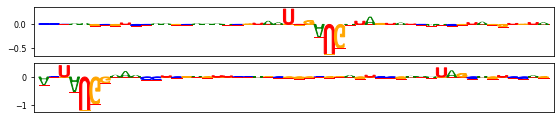

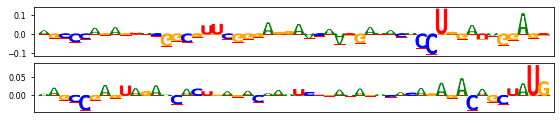

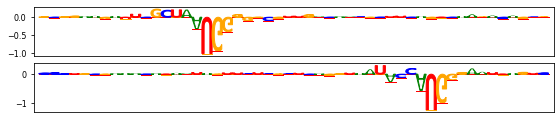

In [39]:
for i in utrans_random:
    plot_attribution(i, mrl_model, samples=2)

5813


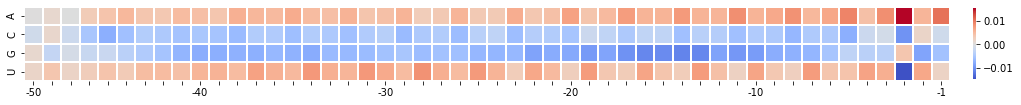

704


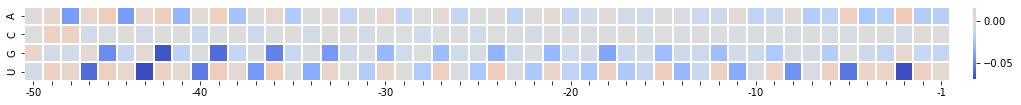

1343


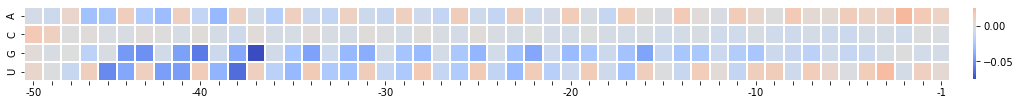

1431


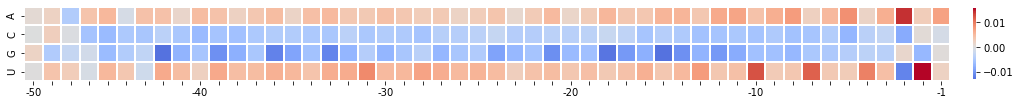

5297


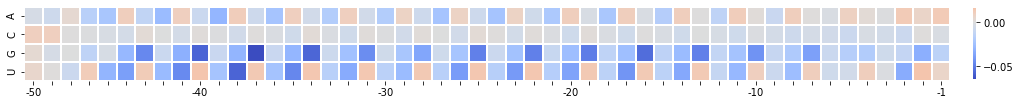

In [40]:
for i in utrans_random:
    plot_meta(i, mrl_model)

We generate barplots to test effect of sequence elements on MRL

/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/my_utils.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['feature'][x] = 'OOF_OV_uORF'
/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/my_utils.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfy['feature'][x] = 'OOF_OV_uORF'


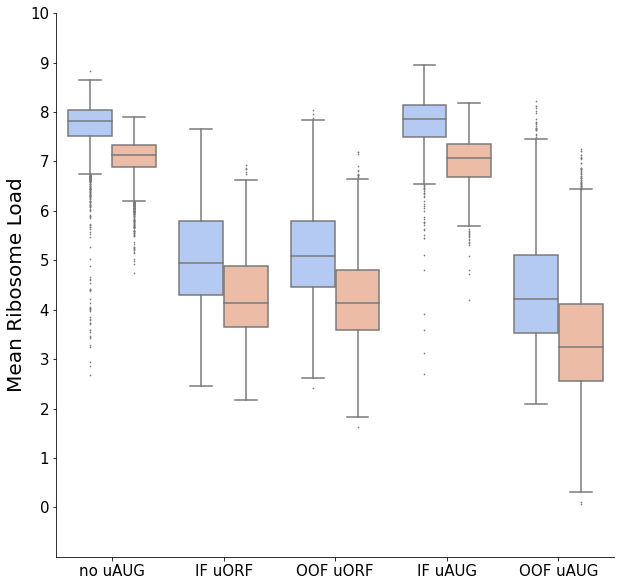

In [18]:
comp_data_random = my_utils.barplot_mrl(test_random)

fig, ax = plt.subplots(figsize = (10,10))
fig = sns.boxplot(data=comp_data_random, x = 'feature', y = 'MRL', hue = 'pred', 
                  palette= 'coolwarm', #{False:'skyblue', True:'orange'}
                  order = ['None', 'IF_uORF', 'OOF_uORF', 'NTEx', 'OOF_OV_uORF'],
                  flierprops={'markerfacecolor':'black', 'markersize':0.8})

fig.set(ylim=(-1,10),yticks=range(0,11,1),
        xlabel='5UTR Sequence Feature',ylabel='Mean Ribosome Load')


plt.xticks([0,1,2,3,4], ['no uAUG', 'IF uORF', 'OOF uORF', 'IF uAUG', 'OOF uAUG'], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Mean Ribosome Load', fontsize=20)
plt.xlabel('')

# calculate sample size per group and median to position labels in the plot
#medians = comp_data_random.groupby(['feature'])['MRL'].median().values
#n = comp_data_random['feature'][:(int(len(comp_data_random)/2))].value_counts().values
#n = [str(x) for x in n.tolist()]
#n = ["n= " + i for i in n]

# add everything to the plot
#pos = range(len(n))
#for tick, label in zip(pos, ax.get_xticklabels()):
#        ax.text(pos[tick], -0.5, n[tick], horizontalalignment='center', size='medium', color='black')

sns.despine()
plt.legend([],[], frameon=False)


We generate plots for the MRL model architecture trained on human utrs

3853


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


69
194
27
536


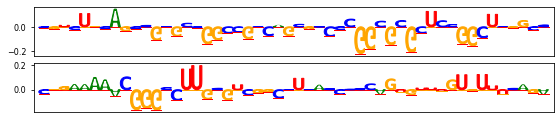

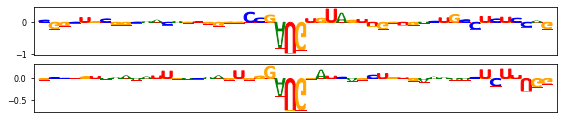

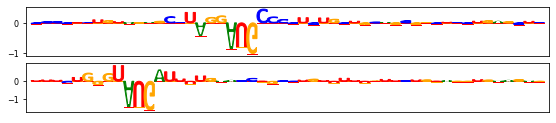

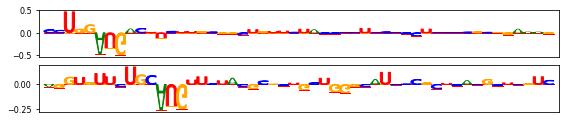

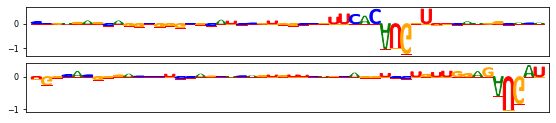

In [42]:
for i in utrans_human:
    plot_attribution(i, hmrl_model, samples=2)

27


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


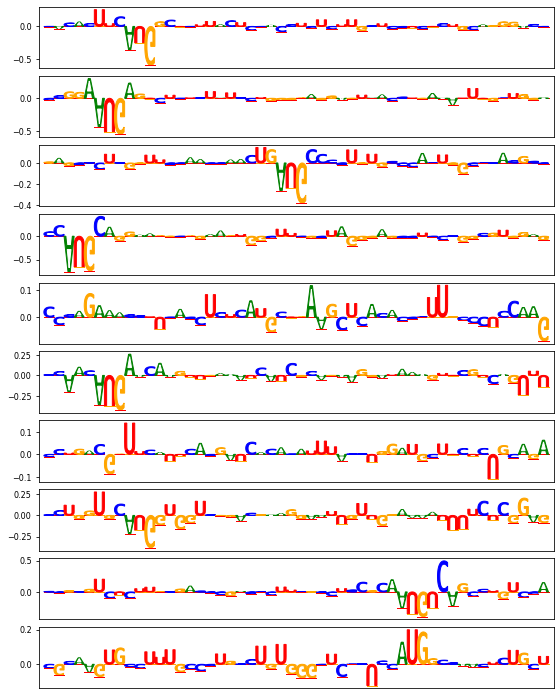

In [45]:
plot_attribution(if_uaug_human, hmrl_model, samples=10)

3853


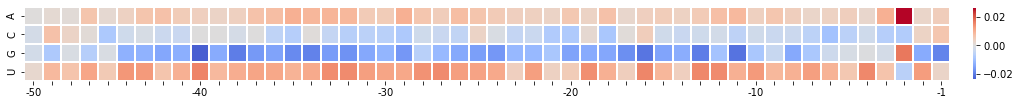

69


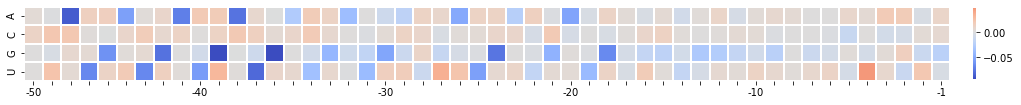

194


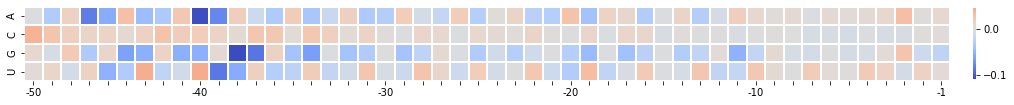

27


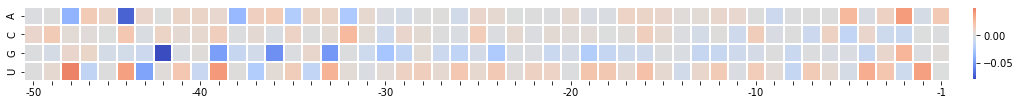

536


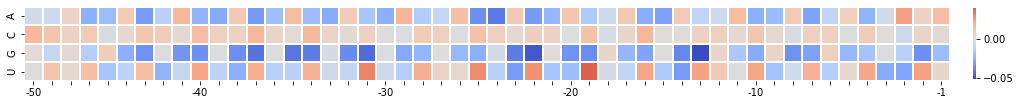

In [43]:
for i in utrans_human:
    plot_meta(i, hmrl_model)

/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/my_utils.py:308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['feature'][x] = 'None'
/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/my_utils.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfy['feature'][x] = 'None'


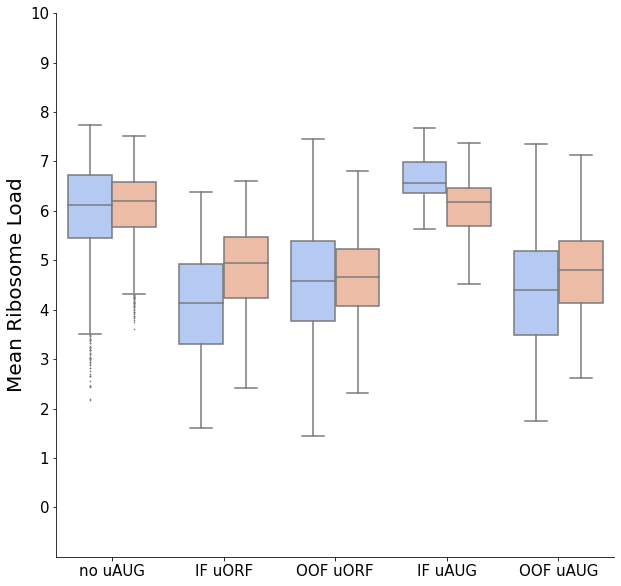

In [19]:
comp_data_human = my_utils.barplot_mrl(test_human)

fig, ax = plt.subplots(figsize = (10,10))
fig = sns.boxplot(data=comp_data_human, x = 'feature', y = 'MRL', hue = 'pred', 
                  palette= 'coolwarm', #{False:'skyblue', True:'orange'}
                  order = ['None', 'IF_uORF', 'OOF_uORF', 'NTEx', 'OOF_OV_uORF'],
                  flierprops={'markerfacecolor':'black', 'markersize':0.8})
fig.set(ylim=(-1,10),yticks=range(0,11,1),
        xlabel='5UTR Sequence Feature',ylabel='Mean Ribosome Load')


plt.xticks([0,1,2,3,4], ['no uAUG', 'IF uORF', 'OOF uORF', 'IF uAUG', 'OOF uAUG'], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Mean Ribosome Load', fontsize=20)
plt.xlabel('')

# calculate sample size per group and median to position labels in the plot
#medians = comp_data_human.groupby(['feature'])['MRL'].median().values
#n = comp_data_human['feature'][:(int(len(comp_data_human)/2))].value_counts().values
#n = [str(x) for x in n.tolist()]
#n = ["n= " + i for i in n]

# add everything to the plot
#pos = range(len(n))
#for tick, label in zip(pos, ax.get_xticklabels()):
#        ax.text(pos[tick], -0.5, n[tick], horizontalalignment='center', size='medium', color='black')

sns.despine()
plt.legend([],[], frameon=False)